## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import warnings

# Filter out deprecation warnings, from Gym's usage of np.bool8, which is deprecated in NumPy version 1.24
warnings.filterwarnings('ignore', category=DeprecationWarning)

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Initialising CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

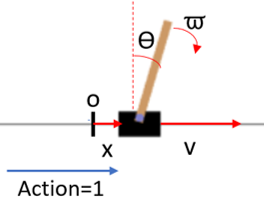

*Image of CartPole environment, full credits to Jian Xu on: https://towardsdatascience.com/how-to-beat-the-cartpole-game-in-5-lines-5ab4e738c93f*

The CartPole environment consists of 4 continuous dimensions of observation/state space:


*   Cart Position, denoted as distance x from origin in above diagram
*   Cart Velocity, denoted as speed v at which cart is moving
*   Pole Angle, denoted as θ
*   Angular Velocity, denoted as ω, the speed at which the pole tilts left/right







## Task 1: Development of an RL agent

For this lab, we choose to use Q-Learning RL agent over Monte Carlo due to the following reasons:
- Monte Carlo only calculate Gt (the return value) at the *end* of an episode and uses it as a target for its policy.
- Q-Learning is a form of temporal difference learning, and calculates Gt at each time step throughout an episode.
- Since the position of the pole is *continuously* moving throughout an episode rather than just once when the cart is pushed, Q-Learning will be more suitable as a RL agent.
- Because Q-Learning is able to calculate and update the value at each time step, it can learn more effectively from a continuous stream of experiences in the CartPole environment

Reference:
*https://huggingface.co/learn/deep-rl-course/en/unit2/mc-vs-td*


### 1.A Creating a Q-table

The Q-table stores the estimated Q-values for each state-action pair in the environment, and each Q-value represents the expected cumulative future reward that the agent can obtain by taking a specific action in a given state.

The agent uses the Q-table to decide which action to take in each state by selecting the action with the highest Q-value. Over time, the Q-table is updated based on the agent's experiences, allowing the agent to learn an optimal policy for the environment.

The CartPole environment has 4 continuous dimensions, as noted in the previous diagram. Since the Q-learning algorithm typically works with discrete state and action spaces, we need to discretize the continuous state space into a finite number of discrete states to create a Q-table that the algorithm can work with:


In [ ]:
num_segments = [40, 50, 80, 80]  # [cart position, cart velocity, pole angle, and pole angular velocity]

# separate each continuous range of each dimension into x number discrete mini-ranges based on num_segments
segments = [
    np.linspace(-4.8, 4.8, num_segments[0]),        # range of Cart Position is from -4.8 to 4.8
    np.linspace(-4, 4, num_segments[1]),            # range of Cart Velocity is from -inf to inf, we assume a reasonable range of -6 to 6
    np.linspace(-0.418, 0.418, num_segments[2]),    # range of Pole Angle is from -0.418 rad to 0.418 rad
    np.linspace(-4, 4, num_segments[3])             # range of Pole Angular Velocity is from -inf to inf, we assume a practical range of -4 to 4
]

# Function that convert a continuous state into discrete state
def discretize_state(state):
    discrete_state = []
    for i in range(len(state)):                                         # loops through each dimension (cart pos., cart velo. etc.)
        discrete_state.append(np.digitize(state[i], segments[i]) - 1)   # np.digitize returns the segment number for each dimension
    return tuple(discrete_state)                                        # returns a 4-element tuple

The continuous linear space of each dimension is separated into 40, 50, 80 and 80 equal segments (or mini-ranges, if you will) in the above code. For each value in the observation, we will then return which segment/range it belongs to using discretize_state().

We placed higher emphasis on pole angle and pole's angular velocity as they are the determining factors in whether an episode ends or not. Hence we split the continuous range into more segments as compared to cart position and cart velocity to better represent the continuous state space so our model can have a higher accuracy.

Next we initialise the Q-Table, we first set all its initial Q-values to be zero to represent that the agent has not yet interacted with the environment:

In [ ]:
# Initialize the Q-table
qTable = np.zeros(num_segments + [env.action_space.n])

In [ ]:
# Print the Q-table
print(num_segments)
print("Number of actions available:", env.action_space.n) # CartPole only has 2 action, 0 or 1. Push left or push right.
print("Q-table shape:", qTable.shape)

[40, 50, 80, 80]
Number of actions available: 2
Q-table shape: (40, 50, 80, 80, 2)


### 1.B. Initialising hyperparameters:

Q-Learning makes use of the following hyperparameters:
- **alpha**: AKA the learning rate. alpha determines the extent at which newly acquire information overrides old information. 0 makes the agent learn nothing, and 1 makes the agent only consider the most recent information. We find a value of 0.2 to be the most optimal based on the tests we conducted.
  - **Improvements:**
    - Traditional Q-Learning simply multiplies a constant alpha value in the Bellman Equation. Here we introduce a more dynamic alpha value.
    - Initial testings showed multiple dips in the cumulative reward graph below, hence we introduced the **smoothing of alpha** to attempt to reduce the severity of dips in cumulative reward. This has the effect of helping the agent make more stable updates to the Q-table as it gains experience, and provide more consistent performance.
    - **alpha_decay**: alpha is multiplied by this factor to reduce it at each step.
    - **alpha_min**: ensures alpha does not reach 0 so that agent is still learning something.
    - Here we keep both starting alpha and minimum alpha to be of low value so that learning is stable (i.e. new values do not immediately have a huge impact on already derived values).


- **gamma**: The discount factor, which determines the importance of future rewards, 0 makes the agent only consider the current reward, while a value approaching 1 make the agent strive for long-term high reward. We find that 0.99 is the most optimal.

- **epsilon**: Probability of agent choosing exploration (i.e. take random action) vs exploitation (i.e. take best known action) Higher value = explore. Lower value = exploit. Initially, we guarantee the exploration (i.e. = 1.0) since we have no prior info on the environment.

- **epsilon_decay**: Controls how fast exploration rate decrease over time. After each episode, epsilon is multiplied by epsilon_decay

- **epsilon_min**: Prevents epsilon from reaching 0 to ensures that the agent is still exploring sometimes and not just exploiting

Reference:
*https://en.wikipedia.org/wiki/Q-learning*

In [ ]:
alpha = 0.2
alpha_decay = 0.999
alpha_min = 0.1

gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01

## 1.C. Q-Learning Agent

We will first train the agent for some number of episodes. Background testings yield 50,0000 episodes as a suitable enough training size for the agent to learn the optimal policy.

In [ ]:
num_episodes = 50000

Next, our Q-Learning agent will return 2 things:
- The trained Q-table, which can be used to make decisions based on the learned policy
- A function that can choose an action based on the current state, using the trained Q-table

In [ ]:
# Implementing Q-Learning agent, train it for 'num_episodes' times
def q_learning(env, q_table, discretize_state, alpha, alpha_decay, alpha_min, gamma, epsilon, epsilon_decay, epsilon_min, num_episodes):

  for episode in range(num_episodes):         # for each episode
      state = discretize_state(env.reset())   # reset each episode
      done = False                            # done = False means episode havent finish
                                              # 2 Conditions to finish: 1. pole fall over 2. 500 time steps taken
      while not done:
          # Epsilon-greedy action selection
          if np.random.rand() < epsilon:          # if random number less than epsilon, explore
              action = env.action_space.sample()
          else:
              action = np.argmax(qTable[state])   # else choose action with highest Q-value (exploit)

          # Take the action and observe the next state and reward. next_state = observation
          next_state, reward, done, info = env.step(action)
          next_state = discretize_state(next_state) # converts next state into discrete values

          # Update the Q-table using the Bellman Equation
          qTable[state + (action,)] = (1 - alpha) * qTable[state + (action,)] + \
                                        alpha * (reward + gamma * np.max(qTable[next_state]))

          state = next_state

      # Decay epsilon, ensuring it doesnt go below epsilon_min limit
      epsilon = max(epsilon_min, epsilon * epsilon_decay)

      # Decay alpha, ensuring it doesn't go below alpha_min limit
      alpha = max(alpha_min, alpha * alpha_decay)

      #  prints the current episode number and the value of epsilon every x episodes, to monitor progress and see how epsilon decays.
      #if episode % 5000 == 0:
         # print(f'Episode: {episode}, Epsilon: {epsilon}')

  # Function to choose an action based on the current state
  def choose_action(state):
      discrete_state = discretize_state(state)
      return np.argmax(qTable[discrete_state])

  return qTable, choose_action

### 1.D. Demonstrate the correctness of the implementation
... by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action.

Finally, we have the following for Task 1:

In [ ]:
# Fill Q-Table, and train the agent.
q_table, q_learning_agent = q_learning(env, qTable, discretize_state, alpha=alpha, \
                                       alpha_decay=alpha_decay, alpha_min=alpha_min, \
                                       gamma=gamma, epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, num_episodes=num_episodes)

observation = env.reset()
action = q_learning_agent(observation) # Agent is called here, using the trained Q-Table
print("Observation:", observation)
print("Chosen action:", action)


Observation: [-0.00372501  0.00261039  0.01044837 -0.00076082]
Chosen action: 1


**Analysis of Task 1 results:**

From the Observation array, we can note that the pole is currently tilted to the right at ~0.01 rad and is very slowly falling to the left, since angular velocity (i.e. last element of array) is a negative.

The agent chose action 1, which is to push the cart to the right, intuitively one can picture that this manoeuvre causes the pole to be tilted to the left, into an upright position, fulfilling our goal to keep pole upright.

## Task 2: Demonstrate the effectiveness of the RL agent

We now run our Q-Learning agent for 100 episodes and plot the cumulative reward graph against all episodes.

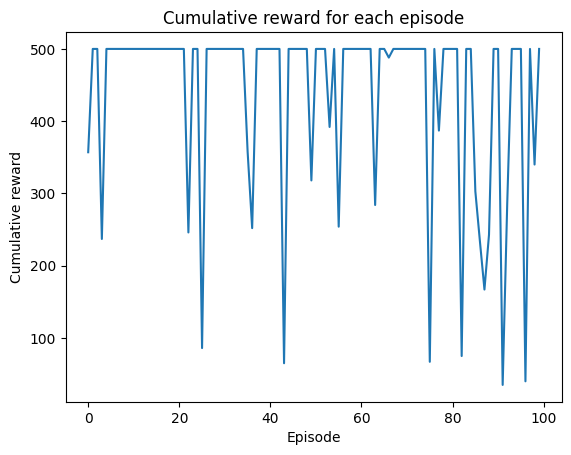

In [ ]:
# Initialize an array to store the cumulative rewards for each episode
episode_rewards = []

# Run the agent for 100 episodes
num_test_episodes = 100
for episode in range(num_test_episodes):
    state = env.reset() # Reset env before each episode
    done = False
    total_reward = 0

    while not done:
        # Use the trained Q-learning agent to choose an action
        action = q_learning_agent(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

    # Record the total reward for this episode
    episode_rewards.append(total_reward)

# Convert the list of rewards to a NumPy array
episode_rewards = np.array(episode_rewards)

# Plot the cumulative rewards for each episode
plt.plot(episode_rewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
# Print the average reward over the 100 episodes
average_reward = episode_rewards.mean()
print("Average cumulative reward:", average_reward)
print("Is my agent good enough?", average_reward > 195)

Average cumulative reward: 440.14
Is my agent good enough? True


**Analysis of Task 2 results:**

*numbers are updated as of last run on 5 Apr 1617hrs*

Initial testing of our agent, without the alpha-smoothing, produced a graph with more fluctuations and suffered more severe dips in performance at certain episodes.

The use of alpha-smoothing reduced the number of dips in cumulative rewards, and the severity of dips in some of it.

As can be seen from the graph plotted above, our agent is mostly able to achieve perfect scores (+500 reward) across a majority of episodes. It experienced some dips in performance, but the number of dips that have cumulative reward > 195 mostly make up the rest.

From the graph, we can only see ~7 out of 100 episodes that have a cumulative reward of < 195.

A possible explanation for this critical failures would be that the agent explores suboptimal actions in some episodes due to the epsilon-greedy strategy used, whereby the agent randomly explores actions with a probability of *epsilon*. This means the agent may occasionally take random (but sub-optimal) actions, despite learning a good policy, leading to lower rewards. Nevertheless this makes up a relatively low chance of failure, at ~7%.

The average cumulative reward of our agent is high, at 440/500, and successfully exceeds the expectation of 195 cumulative reward.

## Task 3: Render one episode played by the agent

In [ ]:
# Record the video
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    # Use the trained Q-learning agent to choose an action
    action = q_learning_agent(observation)
    observation, reward, done, info = env.step(action)
    if done:
        break
env.close()
# Display the recorded video
show_video()

**Analysis of Task 3 result:**

As can be seen from the rendered video, our agent did an excellent job at keeping the pole upright, pushing the car to the right when pole tilts right, and to the left when pole tilts left, as what a human would do intuitively.

## Contributions:
Please clearly state the contribution of each team member in the beginning of the Jupyter notebook if you have more than one member in your team.

Member 1: Sky Lim En Xing (U2223731A)

Member 2: Chermine Cheah Xue Min (U2222126F)

Member 3: Thomas Tan Keat Hao (U2221472J)

We worked collaboratively and equally for all parts of this project.

---


*of Lab Group SCS2, Team 06*

*...as part of SC3000 Lab Assignment 1*